In [1]:
import os
import glob
import json
import sys
import io
import time
from datetime import datetime
from contextlib import redirect_stdout
from IPython.display import display, Image
import matplotlib.pyplot as plt


sys.path.append('..')

from scripts.kununu_scraper import get_all_reviews_for_url, extract_company_name_from_url, generate_filename
from scripts.llm_analyzer import (
    extract_company_name_from_filename,
    process_individual_prompts,
    combine_json_responses,
    get_current_date
)
from scripts.word_cloud_generator import get_wordcloud_image
from scripts.tree_map_generator import get_treemap_figure

## 1. Web Scraping

In [ ]:
url = "https://www.kununu.com/de/draeger/kommentare"
max_reviews = 100

In [3]:
company_name = extract_company_name_from_url(url)
filename = generate_filename(company_name)
save_path = os.path.join("./data", filename)
os.makedirs("./data", exist_ok=True)

print(f"Scraping reviews for: {company_name}")
f = io.StringIO()
with redirect_stdout(f):
    result = get_all_reviews_for_url(
        url,
        save_path=save_path,
        max_reviews=max_reviews
    )
output = f.getvalue()
print(output)

if result:
    num_reviews = len(list(result.values())[0]) if result else 0
    print(f"Successfully scraped {num_reviews} reviews!")
    print(f"File saved to: {save_path}")
else:
    print("No reviews were scraped")

Scraping reviews for: draeger
Collected 10 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/2
Collected 20 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/3
Collected 30 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/4
Collected 40 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/5
Collected 50 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/6
Collected 60 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/7
Collected 70 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/8
Collected 80 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/9
Collected 90 reviews so far...
Navigating to next page: https://www.kununu.com/de/draeger/kommentare/10
Collected 100 reviews so far...
Navigating

## 2. LLM Analysis

2.1. Select and preview a sample review from the scraped file

In [4]:
json_files = glob.glob(os.path.join("./data", "*.json"))
if json_files:
    selected_file = json_files[0]
    print(f"Selected file: {selected_file}")
    with open(selected_file, "r", encoding="utf-8") as f:
        preview_data = json.load(f)
        for url, reviews in preview_data.items():
            print(f"URL: {url}")
            print(f"Number of reviews: {len(reviews)}")
            if reviews:
                print("Sample review:", reviews[0])
            break
else:
    print("No JSON files found in data folder.")

Selected file: ./data\scraped_reviews_draeger_20250620_210814.json
URL: https://www.kununu.com/de/draeger/kommentare
Number of reviews: 50
Sample review: {'review_id': 'draeger_1', 'kn_url': 'https://www.kununu.com/de/draeger/kommentare', 'overall_score': 5.0, 'title': 'Bis heute die beste Entscheidung', 'year': 2025, 'month': 6, 'employee_type': 'Angestellte/r oder Arbeiter/in', 'position': 'Hat zum Zeitpunkt der Bewertung bei Dräger Safety in Stuttgart gearbeitet und diesen Arbeitgeber mehrfach bewertet. (Mitarbeiter:innen dürfen ihren Arbeitgeber einmal im Jahr bewerten.)', 'subcategories': [{'Work-Life-Balance': 'Familie und Beruf lassen sich sehr gut vereinbaren'}, {'Kollegenzusammenhalt': 'Man arbeitet als Team'}]}


2.2. Run LLM analysis on selected file

In [5]:
api_key = "YOUR_API_KEY" # I have removed my API key after running
selected_prompts = [1, 3]

with open(selected_file, "r", encoding="utf-8") as f:
    input_data = json.load(f)

company_name = extract_company_name_from_filename(selected_file)
current_date = get_current_date()
os.makedirs("./responses", exist_ok=True)
os.makedirs("./results", exist_ok=True)

for prompt_num in selected_prompts:
    print(f"Processing prompt {prompt_num}...")
    f = io.StringIO()
    with redirect_stdout(f):
        result = process_individual_prompts(
            input_data,
            prompt_num,
            company_name,
            current_date,
            api_key
        )
    prompt_output = f.getvalue()
    print(prompt_output)
    time.sleep(30)

print("Combining responses...")
f = io.StringIO()
with redirect_stdout(f):
    combine_json_responses(company_name, current_date, selected_prompts)
combine_output = f.getvalue()
print(combine_output)

results_file = f"./results/result_{company_name}_{current_date}.json"
if os.path.exists(results_file):
    with open(results_file, "r", encoding="utf-8") as rf:
        results_data = json.load(rf)
        print("Number of categories analyzed:", len(results_data.get("categories", [])))
        if results_data.get("categories"):
            print("Sample category result:", results_data["categories"][0])


Processing prompt 1...
Processing prompt_1.txt...
Finish reason: 1
Valid response received (18775 characters)

Processing prompt 3...
Processing prompt_3.txt...
Finish reason: 1
Valid response received (6601 characters)

Combining responses...
Loaded response_draeger_20250620_211935_1.json
Loaded response_draeger_20250620_211935_3.json
Combined results saved to: ./results\result_draeger_20250620_211935.json

Number of categories analyzed: 2
Sample category result: {'arbeitsatmosphaere': {'positive_points': [{'point': 'Abwechslungsreiche Arbeitsatmosphäre', 'count': 1, 'references': [{'review_id': 'draeger_15', 'employee_type': 'Angestellte/r oder Arbeiter/in', 'field': 'Vertrieb / Verkauf'}]}, {'point': 'Angenehme und positive Arbeitsatmosphäre', 'count': 5, 'references': [{'review_id': 'draeger_6', 'employee_type': 'Angestellte/r oder Arbeiter/in', 'field': 'Personal / Aus- und Weiterbildung'}, {'review_id': 'draeger_22', 'employee_type': 'Werkstudent/in', 'field': 'IT'}, {'review_id'

# 3. Result Visualizations

Category: arbeitsatmosphaere


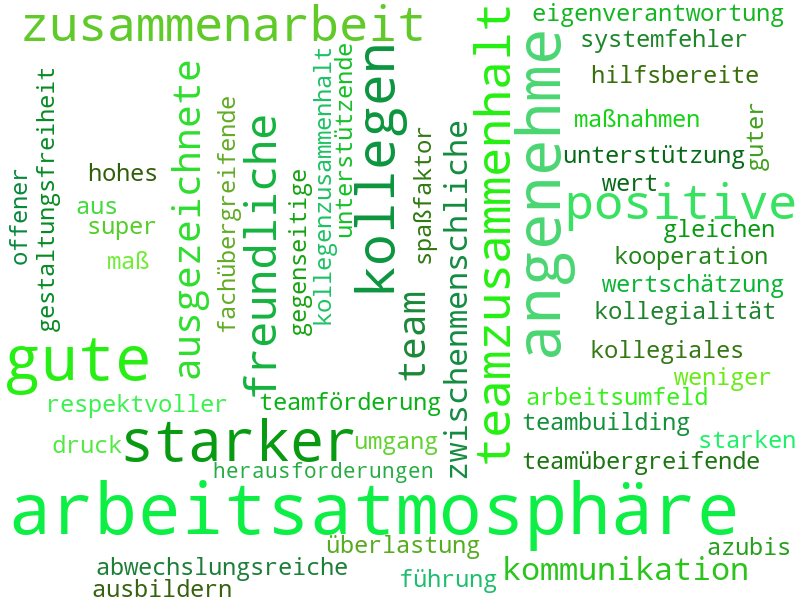

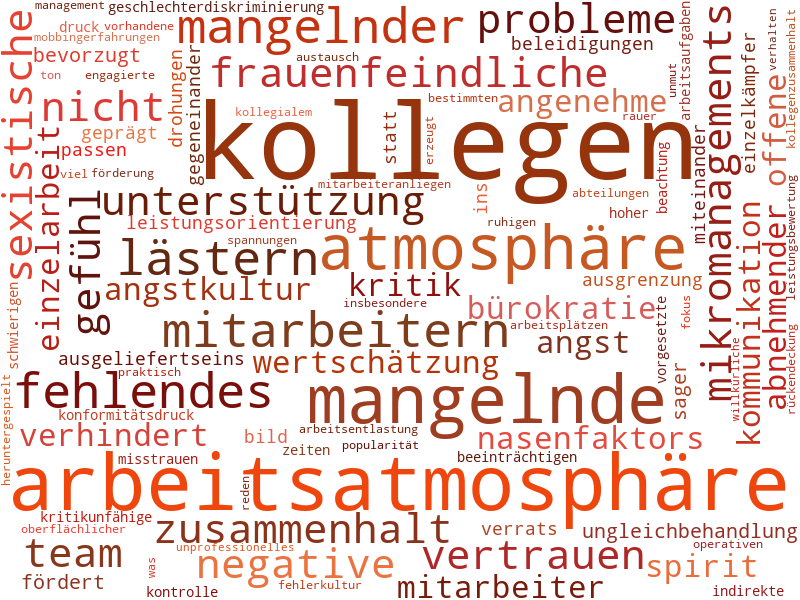

Category: work_life_balance


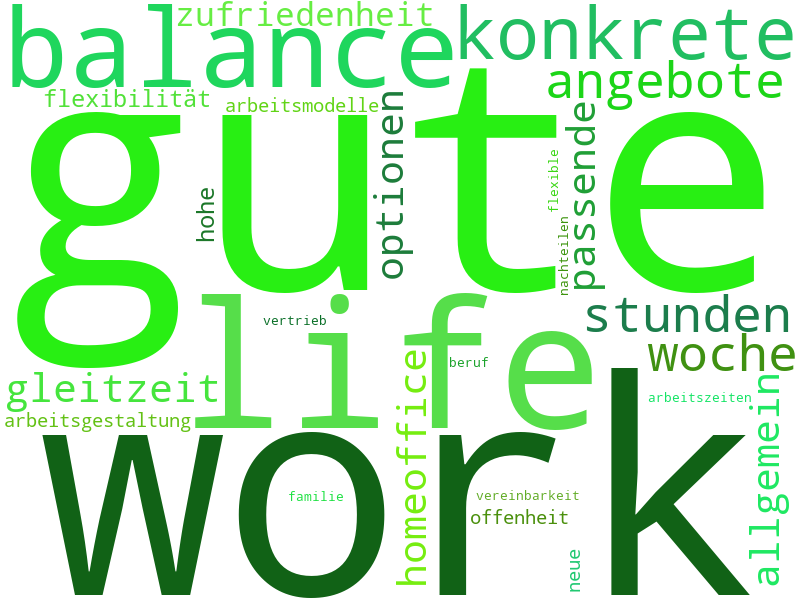

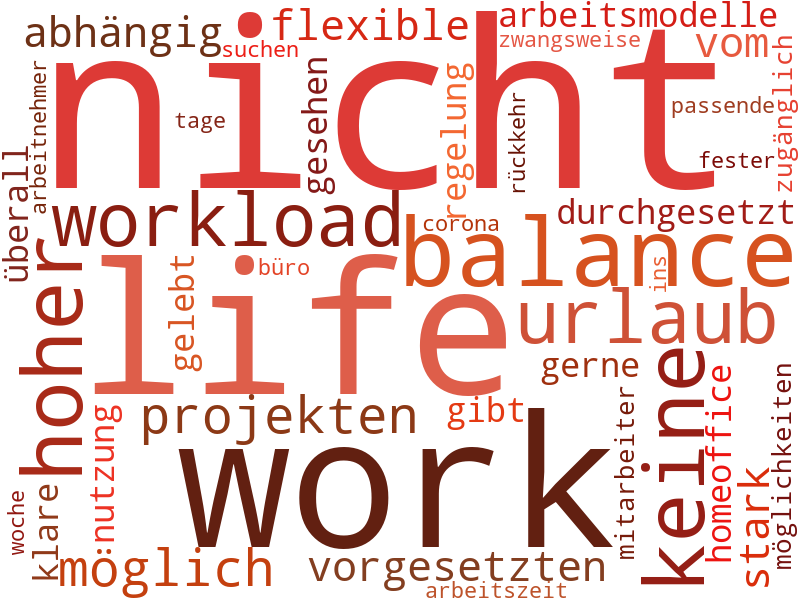

In [6]:
if os.path.exists(results_file):
    categories = results_data.get("categories", [])
    for i, cat_dict in enumerate(categories):
        category = list(cat_dict.keys())[0]
        print(f"Category: {category}")

        img = get_wordcloud_image(results_file, category, "positive_points")
        if img:
            display(img)
        else:
            print("No wordcloud available (positive points).")

        img = get_wordcloud_image(results_file, category, "critical_points")
        if img:
            display(img)
        else:
            print("No wordcloud available (critical points).")

        fig = get_treemap_figure(results_file, category, "positive_points")
        if fig:
            fig.show()
        else:
            print("No treemap available (positive points).")

        fig = get_treemap_figure(results_file, category, "critical_points")
        if fig:
            fig.show()
        else:
            print("No treemap available (critical points).")
